In [28]:
import random
import os
import sys
import csv
import pandas as pd
import numpy as np
import stereo as st
import copy
import scanpy as sc
import anndata as a
import yaml
import scipy.ndimage
import itertools

import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.patches import Patch
from matplotlib.widgets import LassoSelector
from matplotlib import colors as mcolors
from matplotlib import path
from matplotlib.collections import RegularPolyCollection
from matplotlib.widgets import Lasso
import matplotlib.patches as mpatches

from skimage import io
from skimage import color
from skimage import filters
from skimage import restoration
from skimage.draw import disk
from skimage import feature

# workaround for error in skimage import feature
from scipy.spatial import QhullError
from scipy import spatial
#spatial.QhullError = QhullError
#

random.seed(1)

# Sample specific params

In [29]:
sample_name = "E16.5_E1S3"

tissue_analysis = "brain_meninges"

gef_path = f"/mnt/storage3/projects/no_ngsd/ahhammv1_spatial_transcriptomics/data/{sample_name}/SAW_output/04.tissuecut/E16.tissue.gef"
bin_size = 30
region = [0, 14500, 0, 50000]

In [30]:
out_dir = f"/mnt/storage3/projects/no_ngsd/ahhammv1_spatial_transcriptomics/edge_analysis/results/whole_boundary/{sample_name}/"
testing_out_dir = out_dir + "testing/"

try:
    os.makedirs(testing_out_dir, exist_ok=True)
except OSError as error:
    print(error)   

In [4]:
data_BACKUP = st.io.read_gef(file_path=gef_path, 
                             bin_size=bin_size, 
                             region=region)


[2025-07-09 15:46:48][Stereo][596702][MainThread][140619690166080][reader][1241][INFO]: the matrix has 107475 cells, and 44088 genes.
[2025-07-09 15:46:48][Stereo][596702][MainThread][140619690166080][reader][1242][INFO]: read_gef end.


In [5]:
# basic preprocessing________________________________________________
data_BACKUP.tl.cal_qc()

[2025-07-09 15:46:49][Stereo][596702][MainThread][140619690166080][st_pipeline][41][INFO]: start to run cal_qc...
[2025-07-09 15:46:50][Stereo][596702][MainThread][140619690166080][st_pipeline][44][INFO]: cal_qc end, consume time 0.8305s.


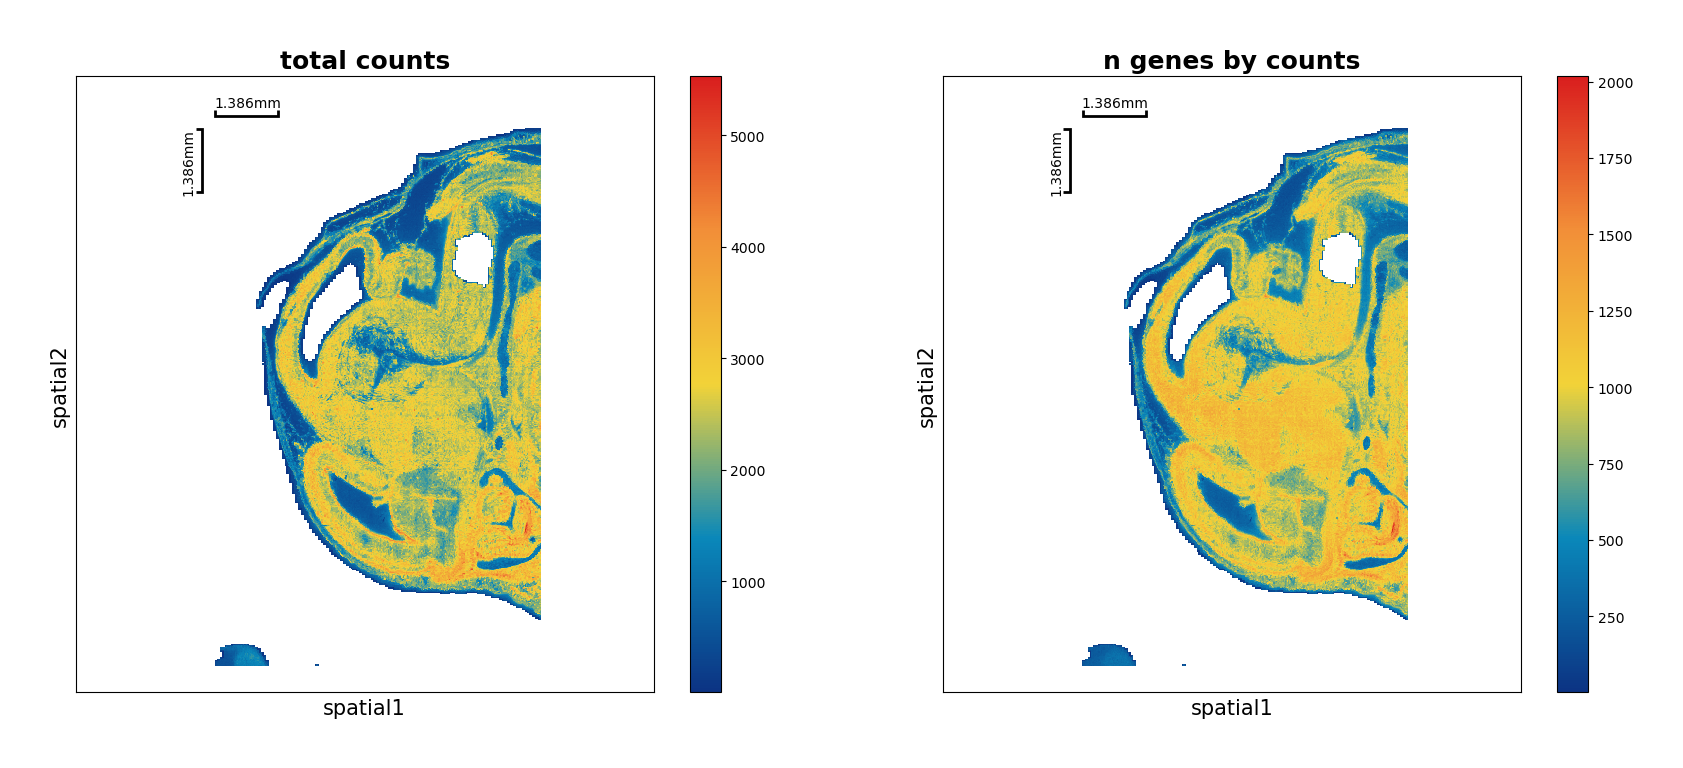

In [6]:
data_BACKUP.plt.spatial_scatter(out_path=f"{out_dir}{sample_name}_scatter_before.png",
                                out_dpi=300)

In [7]:
plt.close("all")
for qc_metric in ['total_counts', 'n_genes_by_counts', 'pct_counts_mt']:
    plt.violinplot(data_BACKUP.cells[qc_metric])
    plt.title(f"{sample_name}_{qc_metric}_before")
    plt.savefig(f"{out_dir}{sample_name}_{qc_metric}_before.png", dpi=300)
    plt.close("all")
    #plt.show() #closes them too

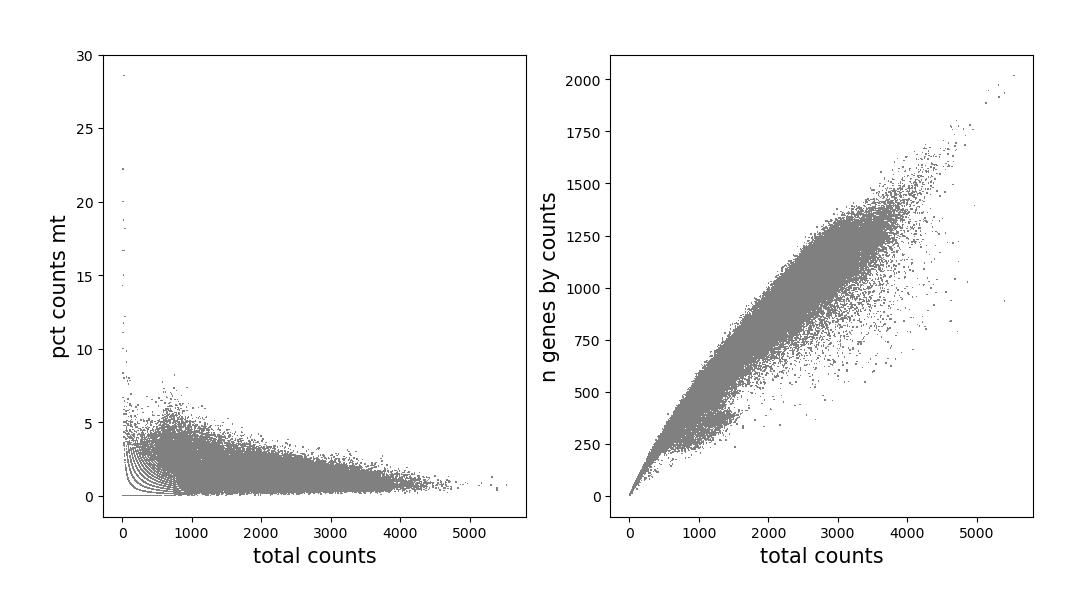

In [8]:
data_BACKUP.plt.genes_count(out_path=f"{out_dir}{sample_name}_count_before.png",
                            out_dpi=300)

In [9]:
data_BACKUP.tl.raw_checkpoint()

## filtering parameters

In [10]:
min_gene = 100                  # cut off x axis in count plot
min_n_genes_by_counts = 50     # cut off y axis in count plot
pct_counts_mt = 7

[2025-07-09 15:46:59][Stereo][596702][MainThread][140619690166080][st_pipeline][41][INFO]: start to run filter_cells...
[2025-07-09 15:47:02][Stereo][596702][MainThread][140619690166080][st_pipeline][44][INFO]: filter_cells end, consume time 2.5402s.


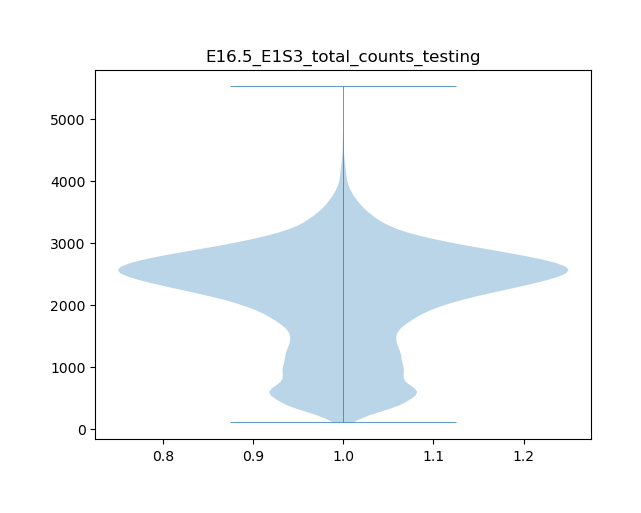

[2025-07-09 15:47:02][Stereo][596702][MainThread][140619690166080][st_pipeline][41][INFO]: start to run filter_cells...
[2025-07-09 15:47:03][Stereo][596702][MainThread][140619690166080][st_pipeline][44][INFO]: filter_cells end, consume time 1.3163s.


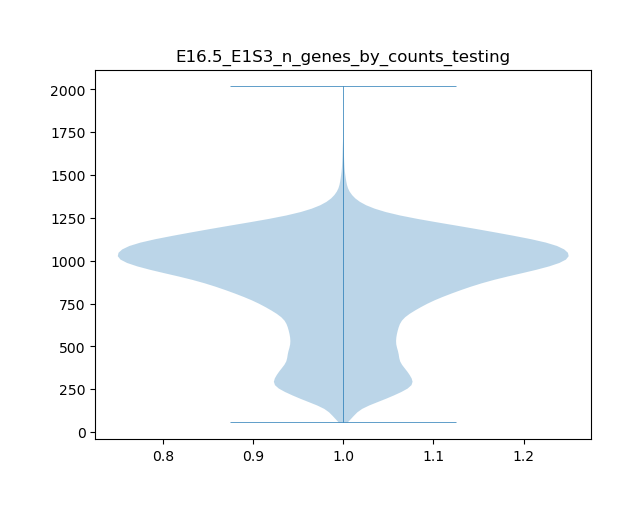

[2025-07-09 15:47:04][Stereo][596702][MainThread][140619690166080][st_pipeline][41][INFO]: start to run filter_cells...
[2025-07-09 15:47:05][Stereo][596702][MainThread][140619690166080][st_pipeline][44][INFO]: filter_cells end, consume time 1.3139s.


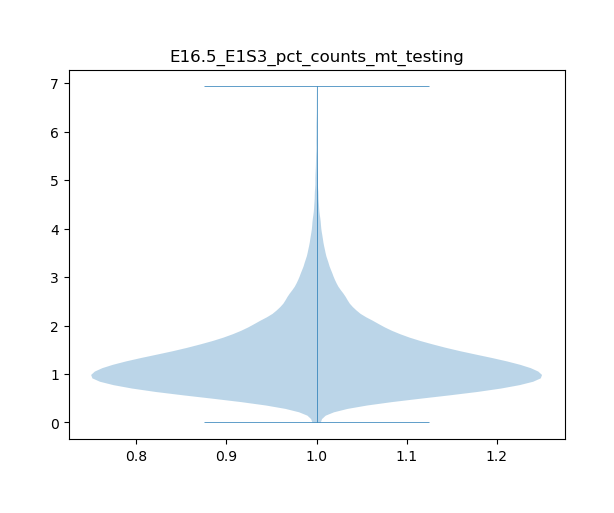

[2025-07-09 15:47:06][Stereo][596702][MainThread][140619690166080][st_pipeline][41][INFO]: start to run filter_cells...
[2025-07-09 15:47:07][Stereo][596702][MainThread][140619690166080][st_pipeline][44][INFO]: filter_cells end, consume time 1.3148s.
[2025-07-09 15:47:08][Stereo][596702][MainThread][140619690166080][st_pipeline][41][INFO]: start to run filter_cells...
[2025-07-09 15:47:10][Stereo][596702][MainThread][140619690166080][st_pipeline][44][INFO]: filter_cells end, consume time 2.2023s.


Column
    [0] Markdown(str)
    [1] Row
        [0] TextInput(name='file name', placeholder='Enter a file name...', width=200)
        [1] Select(name='file format', options=['png', 'pdf'], value='png', width=60)
        [2] IntInput(name='dpi', placeholder='Enter the dip...', start=0, value=100, width=200)
    [2] Row
        [0] Button(button_type='primary', name='export', width=100)
        [1] StaticText(width=800)

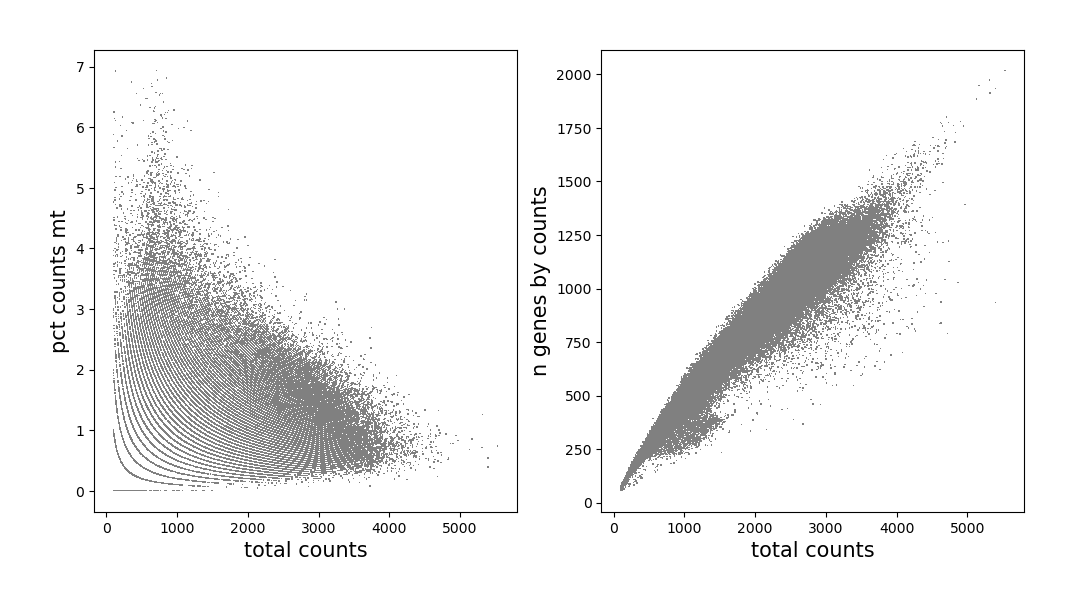

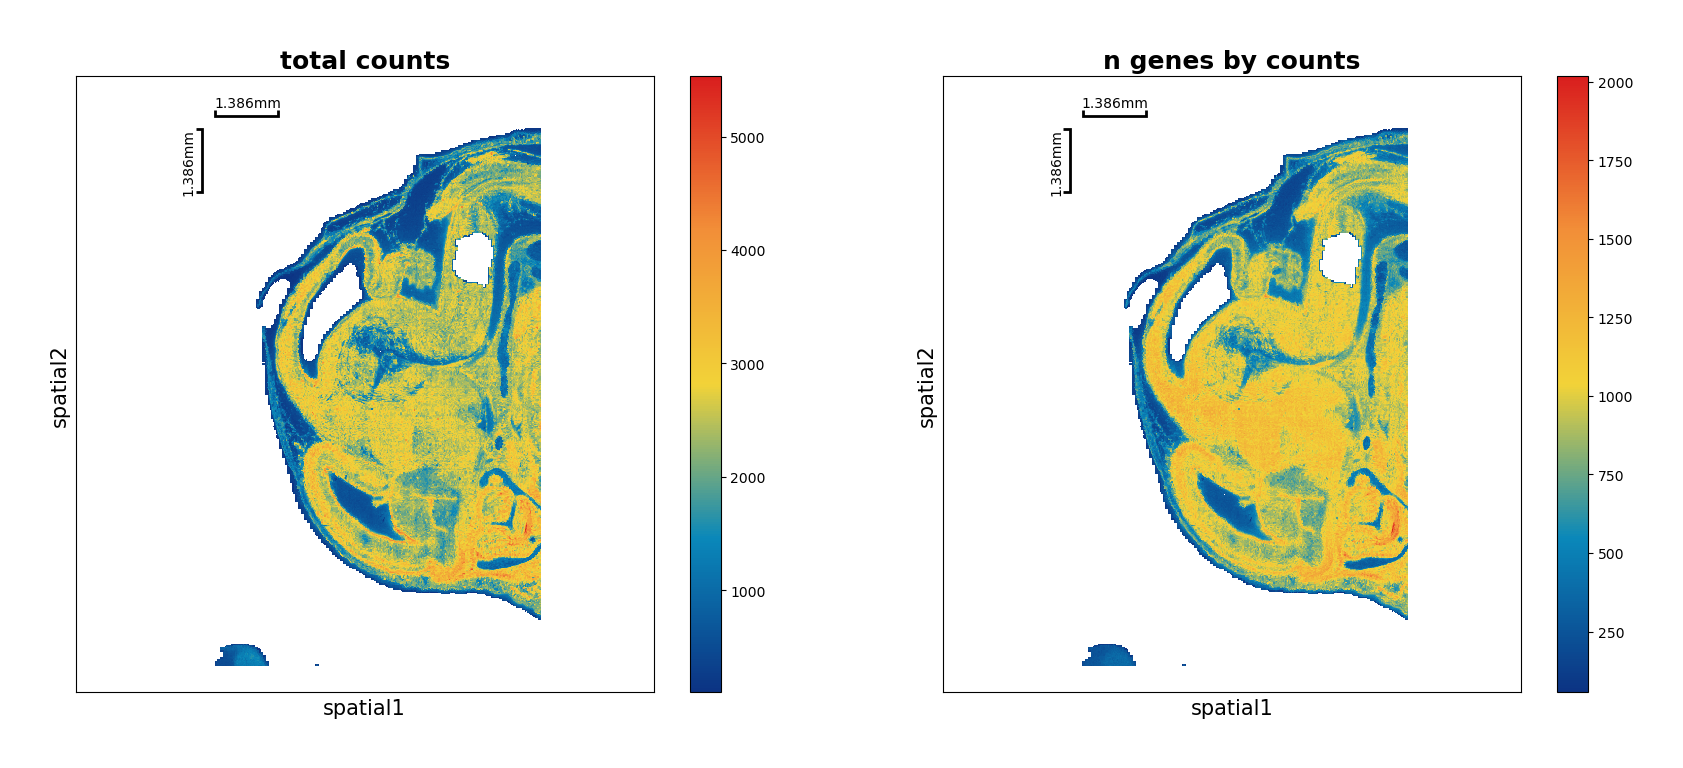

In [11]:
# testing different params
for qc_metric in ['total_counts', 'n_genes_by_counts', 'pct_counts_mt']:
    plt.violinplot(data_BACKUP.tl.filter_cells(min_gene=min_gene,
                            min_n_genes_by_counts=min_n_genes_by_counts,
                            pct_counts_mt=pct_counts_mt,
                            inplace=False
                            ).cells[qc_metric])
    plt.title(f"{sample_name}_{qc_metric}_testing")
    plt.show() #closes them too



data_BACKUP.tl.filter_cells(min_gene=min_gene,
                            min_n_genes_by_counts=min_n_genes_by_counts,
                            pct_counts_mt=pct_counts_mt,
                            inplace=False
                            ).plt.genes_count()
#plt.savefig(f"{testing_out_dir}{sample_name}_count_testing.png")
#plt.close()

data_BACKUP.tl.filter_cells(min_gene=min_gene,
                            min_n_genes_by_counts=min_n_genes_by_counts,
                            pct_counts_mt=pct_counts_mt,
                            inplace=False
                            ).plt.spatial_scatter()
#plt.savefig(f"{testing_out_dir}{sample_name}_scatter_testing.png")
#plt.close()


# applying params

In [12]:
data_BACKUP.tl.filter_cells(min_gene=min_gene,
                            min_n_genes_by_counts=min_n_genes_by_counts,
                            pct_counts_mt=pct_counts_mt,
                            inplace=True
                            )

for qc_metric in ['total_counts', 'n_genes_by_counts', 'pct_counts_mt']:
    plt.violinplot(data_BACKUP.cells[qc_metric])
    plt.title(f"{sample_name}_{qc_metric}_filtered")
    plt.savefig(f"{out_dir}{sample_name}_{qc_metric}_filtered.png", dpi=300)
    plt.close() #closes them too

data_BACKUP.plt.genes_count()
plt.savefig(f"{out_dir}{sample_name}_count_filtered.png")
plt.close()

data_BACKUP.plt.spatial_scatter()
plt.savefig(f"{out_dir}{sample_name}_scatter_filtered.png")
plt.close()

data_BACKUP.tl.raw_checkpoint()

[2025-07-09 15:47:15][Stereo][596702][MainThread][140619690166080][st_pipeline][41][INFO]: start to run filter_cells...
[2025-07-09 15:47:17][Stereo][596702][MainThread][140619690166080][st_pipeline][44][INFO]: filter_cells end, consume time 1.7583s.


In [ ]:
plt.close("all")
#if tissue_analysis == "liver":
#    plot_heatmap(data_BACKUP, f"{out_dir}liver_markers.pdf", ["Afp", "Fgb", "Hnf4a", "Rbp4", "Trf"])


#fig, axs = plt.subplots(nrows=3, ncols=4)
plot_heatmap_stereo(data_BACKUP, genes=["Defb11", "Kcne2", "Htr2c", "Dynlrb2" , "Ttr", "Enpp2", "Igfbp2"], title="Choroid plexus", out_path=f"{out_dir}{sample_name}_Choroid_plexus.png", out_dpi=300)
#plot_heatmap_stereo(data_BACKUP, genes=["Rspo1", "Rspo3", "Dynlrb2"], title="Choroid plexus progenitor", out_path=f"{out_dir}{sample_name}_choroid_plexus_progenitor.png", out_dpi=300)
plot_heatmap_stereo(data_BACKUP, genes=["Tfap2b", "Lhx9", "Zic1"], title="Dorsal midbrain neuron", out_path=f"{out_dir}{sample_name}_dorsal_midbrain_neuron.png", out_dpi=300)
plot_heatmap_stereo(data_BACKUP, genes=["Neurod6", "Tbr1", "Neurod2"], title="Forebrain neuron", out_path=f"{out_dir}{sample_name}_forebrain_neuron.png", out_dpi=300)
plot_heatmap_stereo(data_BACKUP, genes=["Fabp7", "Sox2", "Pou3f3"], title="Forebrain radial glia", out_path=f"{out_dir}{sample_name}_forebrain_radial_glia.png", out_dpi=300)
plot_heatmap_stereo(data_BACKUP, genes=["Ptgds", "Trpm3", "Ranbp3l"], title="Meninges cell", out_path=f"{out_dir}{sample_name}_Meninges_cell.png", out_dpi=300)
plot_heatmap_stereo(data_BACKUP, genes=["Onecut2", "Otx2"], title="Meninges", out_path=f"{out_dir}{sample_name}_meninges.png", out_dpi=300)
plot_heatmap_stereo(data_BACKUP, genes=["Rtn1", "Nnat", "Stmn2"], title="Mid-/hindbrain and spinal cord neuron", out_path=f"{out_dir}{sample_name}_mid_and_hindbrain_and_spinal_cord_neuron.png", out_dpi=300)
plot_heatmap_stereo(data_BACKUP, genes=["Sox2", "Sox1", "Fabp7", "Pou3f2", "Foxd1"], title="Brain", out_path=f"{out_dir}{sample_name}_brain.png", out_dpi=300)
#plot_heatmap_stereo(data_BACKUP, genes=["Tcf7l2", "Ntng1", "Tenm2"], title="Diencephalon neuron", out_path=f"{out_dir}{sample_name}_diencephalon_neuron.png", out_dpi=300)
#plot_heatmap_stereo(data_BACKUP, genes=["Flrt2", "Eda", "Tbx18"], title="Neural crest", out_path=f"{out_dir}{sample_name}_neural_crest.png", out_dpi=300)
plot_heatmap_stereo(data_BACKUP, genes=["Tcf7l2", "Ntng1", "Tenm2"], title="Diencephalon neuron", out_path=f"{out_dir}{sample_name}_diencephalon_neuron.png", out_dpi=300)
plot_heatmap_stereo(data_BACKUP, genes=["Eln", "Fbln5"], title="Blood vessel", out_path=f"{out_dir}{sample_name}_blood_vessel.png", out_dpi=300)
plot_heatmap_stereo(data_BACKUP, genes=["Krt15", "Krt5"], title="Epidermis", out_path=f"{out_dir}{sample_name}_epidermis.png", out_dpi=300)

# testing
genes=[["Lhx2", "Gli3"],
       ["Spc25", "Qk"],
       ["Tcf4", "Pantr1"],
       ["Dlx1", "Dhfr"],
       ["Dlx1", "Dlx5"],
       ["Ccnd2", "Reln"],
       ["Neurod6", "Tbr1", "Eomes"],
       ["Map1b", "Bcl11b"],
       ["Tcf4", "Satb2"],
       ["Nfib", "Rbfox1"],
       ["Snca", "Nts"],
       ["Otp", "Peg10"],
       ["Pcp4", "Igsf5", "Adarb2"],
       ["Tcf7l2", "Kitl"],
       ["Vim", "Hes5"],
       ["Shox2", "Lhx9"],
       ["Lhx9", "Pcp4"],
       ["Th", "Snca"],
       ["Phgdh", "Dbi"],
       ["Glis3", "Lrp4", "Gria1"],
       ["Insm1", "Pvalb"],
       ["Map1b", "Lrba"],
       ["Slc1a3", "Tnc"],
       ["Hoxa5", "Msx1"],
       ["Nefl", "Sncg", "Nefm"],
       ["Ebf1", "Ebf2"],
       ["Nrg3", "Snhg11"],
       ["Aldh1l1", "Slc1a3", "Ptprz1"],
       ["Gad1", "Gad2"],
       ["Mest", "Matn1"],
       ["Rspo1", "Rspo3", "Dynlrb2"],
       ["Ttr", "Dynlrb2"],
       ["Ftl1", "Lgals1"],
       ["Dcn", "Cdh11"]]
for gene_set in genes:
    plot_heatmap_stereo(data_BACKUP, genes=gene_set, title="", out_path=f"{testing_out_dir}{sample_name}_{*gene_set,}.png", out_dpi=300)


In [14]:
data = copy.deepcopy(data_BACKUP)
data.tl.raw_checkpoint()

# running leiden clustering
data.tl.sctransform(res_key='sctransform', n_genes=2000, inplace=True)
data.tl.pca(use_highly_genes=False, n_pcs=30, res_key='pca')
data.tl.neighbors(pca_res_key='pca', n_pcs=30, res_key='neighbors')
data.tl.umap(pca_res_key='pca', neighbors_res_key='neighbors', res_key='umap')

[2025-07-09 15:47:24][Stereo][596702][MainThread][140619690166080][st_pipeline][41][INFO]: start to run sctransform...
[2025-07-09 15:47:26][Stereo][596702][MainThread][140619690166080][sctransform][89][INFO]: using default random_seed 1448145, will run SCT without randomness
[2025-07-09 15:48:04][Stereo][596702][MainThread][140619690166080][vst][123][INFO]: gene-cell umi shape (32182, 106932), n_genes 2000 n_cells 5000
[2025-07-09 15:48:32][Stereo][596702][MainThread][140619690166080][vst][137][INFO]: get_model_pars finished, cost 23.17974877357483 seconds
[2025-07-09 15:48:35][Stereo][596702][MainThread][140619690166080][vst][307][INFO]: ksmooth finished, cost 1.487431287765503 seconds
[2025-07-09 15:48:35][Stereo][596702][MainThread][140619690166080][vst][155][INFO]: reg_model_pars finished, cost 3.4674274921417236 seconds
[2025-07-09 15:49:16][Stereo][596702][MainThread][140619690166080][vst][180][INFO]: pearson_residual cost 40.493191957473755 seconds
[2025-07-09 16:04:07][Stereo]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs


[2025-07-09 16:05:50][Stereo][596702][MainThread][140619690166080][st_pipeline][44][INFO]: umap end, consume time 56.7787s.


In [15]:
plot_clustering_ranges(data, sample_name, f"{testing_out_dir}", leiden_range=[0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.17, 0.2, 0.23])

[2025-07-09 16:05:50][Stereo][596702][MainThread][140619690166080][st_pipeline][41][INFO]: start to run leiden...


Plotting ranges of clustering resolutions
Working on resolution: 0.05


[2025-07-09 16:06:02][Stereo][596702][MainThread][140619690166080][st_pipeline][44][INFO]: leiden end, consume time 12.3745s.
[2025-07-09 16:06:04][Stereo][596702][MainThread][140619690166080][st_pipeline][41][INFO]: start to run leiden...


Working on resolution: 0.07


[2025-07-09 16:06:26][Stereo][596702][MainThread][140619690166080][st_pipeline][44][INFO]: leiden end, consume time 22.5173s.
[2025-07-09 16:06:27][Stereo][596702][MainThread][140619690166080][st_pipeline][41][INFO]: start to run leiden...


Working on resolution: 0.09


[2025-07-09 16:06:45][Stereo][596702][MainThread][140619690166080][st_pipeline][44][INFO]: leiden end, consume time 17.3999s.
[2025-07-09 16:06:46][Stereo][596702][MainThread][140619690166080][st_pipeline][41][INFO]: start to run leiden...


Working on resolution: 0.11


[2025-07-09 16:07:07][Stereo][596702][MainThread][140619690166080][st_pipeline][44][INFO]: leiden end, consume time 21.2639s.
[2025-07-09 16:07:09][Stereo][596702][MainThread][140619690166080][st_pipeline][41][INFO]: start to run leiden...


Working on resolution: 0.13


[2025-07-09 16:07:39][Stereo][596702][MainThread][140619690166080][st_pipeline][44][INFO]: leiden end, consume time 30.5132s.
[2025-07-09 16:07:42][Stereo][596702][MainThread][140619690166080][st_pipeline][41][INFO]: start to run leiden...


Working on resolution: 0.15


[2025-07-09 16:08:00][Stereo][596702][MainThread][140619690166080][st_pipeline][44][INFO]: leiden end, consume time 17.4557s.
[2025-07-09 16:08:01][Stereo][596702][MainThread][140619690166080][st_pipeline][41][INFO]: start to run leiden...


Working on resolution: 0.17


[2025-07-09 16:08:27][Stereo][596702][MainThread][140619690166080][st_pipeline][44][INFO]: leiden end, consume time 26.0648s.
[2025-07-09 16:08:28][Stereo][596702][MainThread][140619690166080][st_pipeline][41][INFO]: start to run leiden...


Working on resolution: 0.2


[2025-07-09 16:08:44][Stereo][596702][MainThread][140619690166080][st_pipeline][44][INFO]: leiden end, consume time 15.8676s.
[2025-07-09 16:08:46][Stereo][596702][MainThread][140619690166080][st_pipeline][41][INFO]: start to run leiden...


Working on resolution: 0.23


[2025-07-09 16:09:12][Stereo][596702][MainThread][140619690166080][st_pipeline][44][INFO]: leiden end, consume time 26.5478s.


## Calculate final Leiden result

In [16]:
final_leiden_res = 0.07
data.tl.leiden(neighbors_res_key="neighbors", 
               res_key="leiden", 
               resolution=final_leiden_res, 
               random_state=1)

[2025-07-09 16:09:14][Stereo][596702][MainThread][140619690166080][st_pipeline][41][INFO]: start to run leiden...
[2025-07-09 16:09:36][Stereo][596702][MainThread][140619690166080][st_pipeline][44][INFO]: leiden end, consume time 22.2551s.


Setting cluster names.


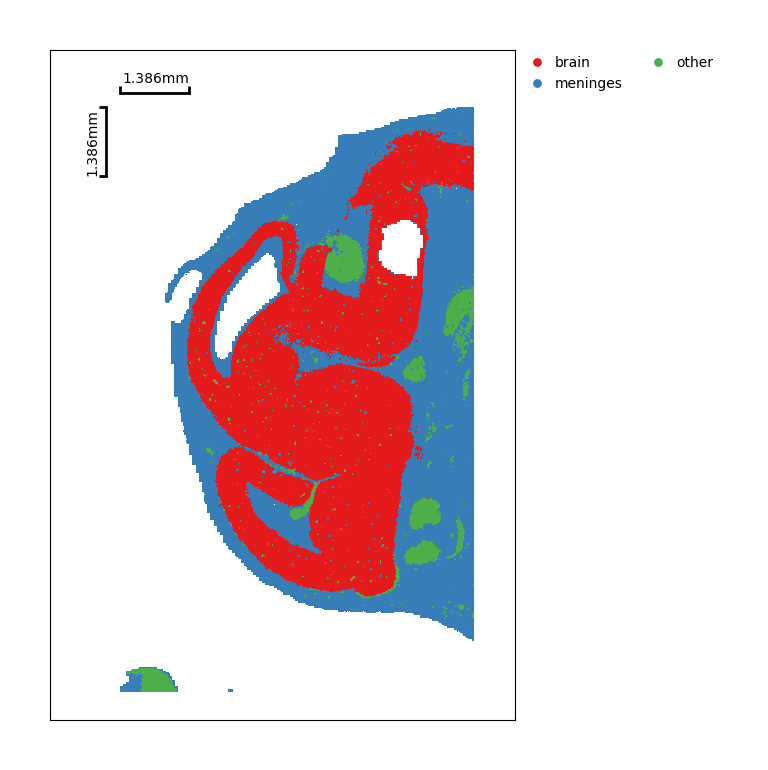

In [17]:
set_cluster_names(data, 
                  final_leiden_res,
                  dict([(1, "brain"), (2, "meninges"), (3, "meninges"), (4, "brain")]),
                  verbose = True, 
                  annotation_key="leiden_annotated",
                  algorithm="leiden")

## Conversion to anndata

In [18]:
anndata = st.io.stereo_to_anndata(data, flavor="scanpy")
anndata_BACKUP = st.io.stereo_to_anndata(data_BACKUP, flavor="scanpy")
sc.pp.normalize_total(anndata_BACKUP, target_sum=1e4)
anndata_BACKUP.obs = anndata.obs

anndata = copy.deepcopy(anndata_BACKUP)

[2025-07-09 16:09:37][Stereo][596702][MainThread][140619690166080][reader][821][INFO]: Adding sample in adata.obs['orig.ident'].
[2025-07-09 16:09:37][Stereo][596702][MainThread][140619690166080][reader][824][INFO]: Adding data.position as adata.obsm['spatial'] .
[2025-07-09 16:09:37][Stereo][596702][MainThread][140619690166080][reader][829][INFO]: Adding data.position as adata.obs['x'] and adata.obs['y'] .
[2025-07-09 16:09:37][Stereo][596702][MainThread][140619690166080][reader][881][INFO]: Adding data.tl.result['pca'] into adata.obsm['X_pca'] .
[2025-07-09 16:09:37][Stereo][596702][MainThread][140619690166080][reader][889][INFO]: Adding data.tl.result['neighbors']['connectivities'] into adata.obsp['connectivities'] .
[2025-07-09 16:09:37][Stereo][596702][MainThread][140619690166080][reader][890][INFO]: Adding data.tl.result['neighbors']['nn_dist'] into adata.obsp['distances'] .
[2025-07-09 16:09:37][Stereo][596702][MainThread][140619690166080][reader][893][INFO]: Adding info into ad

Have to check if x and y coordinates are actually integers, can cause awful issues if they arent (floating point inaccuracy, casting int(0.99999) = 0, etc)
filtering regions by size
no region num key column found. If first pass, all good


/tmp/ipykernel_596702/334753832.py:607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df[["y", "x"]] = small_df[["y", "x"]].astype("int")


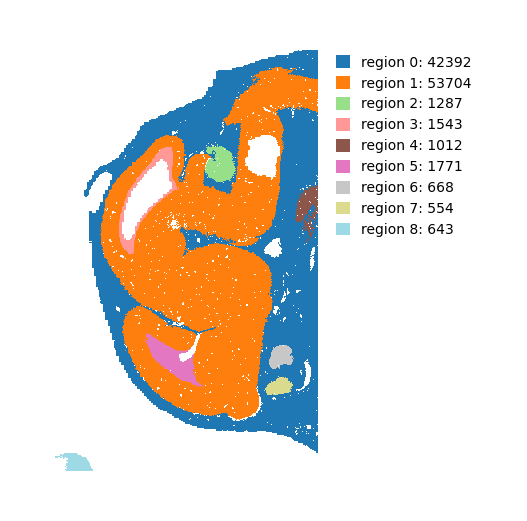

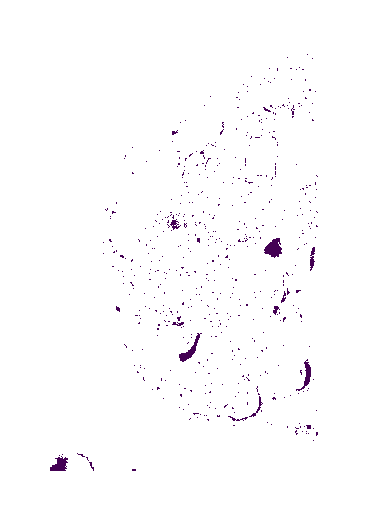

In [19]:
%matplotlib inline
# remove clusters that are too small
plt.close("all")
anndata.obs = filter_regions(anndata,
                                 column_to_filter_key="leiden_annotated", 
                                 filtered_column_key ="filtered_annotated", 
                                 region_num_key="region_num_key",
                                 min_region_size=500)

In [20]:
anndata.obs = set_annotation_by_region(anndata.obs, 
                                       region=3, 
                                       annotation="ventricle",
                                       annotation_key="filtered_annotated",
                                       region_num_key="region_num_key")
anndata.obs = set_annotation_by_region(anndata.obs, 
                                       region=5, 
                                       annotation="ventricle",
                                       annotation_key="filtered_annotated",
                                       region_num_key="region_num_key")

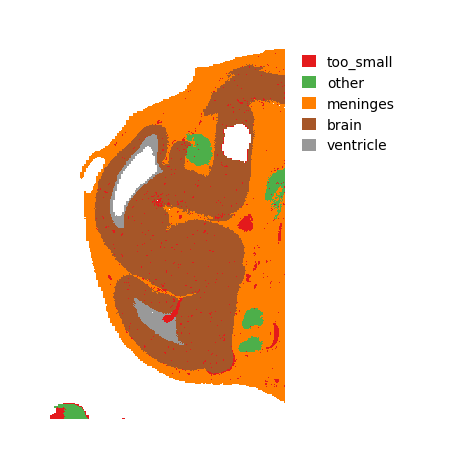

In [21]:
plt.close("all")
plot_obs_column(anndata, "filtered_annotated")

In [22]:
anndata.obs = find_boundary_distances(anndata, 
                                excluded_clusters = ["too_small", "other"],
                                clusters_key="filtered_annotated", 
                                is_boundary_key_prefix="is_boundary_",
                                boundary_dist_key_prefix="boundary_dist_",
                                min_boundary_length = 400,
                                boundary_range = 1,
                                max_dist = 20,
                                verbose=True,
                                print_modulo=5)

marking boundary spots
detecting boundaries between brain and meninges
no boundary column found. If first pass, all good
running boundary_recursion
calculating spots with boundary distance: 20
calculating spots with boundary distance: 15
calculating spots with boundary distance: 10
calculating spots with boundary distance: 5
no boundary dist column found. If first pass, all good
detecting boundaries between brain and ventricle
no boundary column found. If first pass, all good
running boundary_recursion
calculating spots with boundary distance: 20
calculating spots with boundary distance: 15
calculating spots with boundary distance: 10
calculating spots with boundary distance: 5
no boundary dist column found. If first pass, all good
detecting boundaries between meninges and ventricle
no boundary column found. If first pass, all good
running boundary_recursion
calculating spots with boundary distance: 20
calculating spots with boundary distance: 15
calculating spots with boundary distanc

In [23]:
#anndata.obs=anndata.obs.drop(columns=["boundary_dist_brain_ventricle", "boundary_dist_brain_meninges", "boundary_dist_meninges_ventricle"], errors="raise")

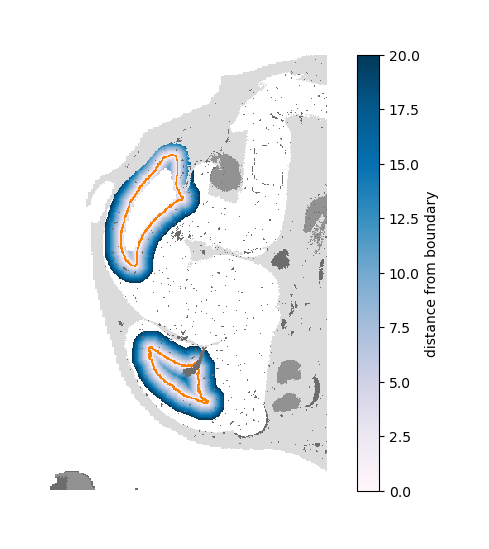

In [24]:
plt.close("all")
plot_boundary_distances(anndata, 
                    boundary_dist_key="boundary_dist_brain_ventricle", 
                    verbose=True, 
                    manual_selection_key=None)

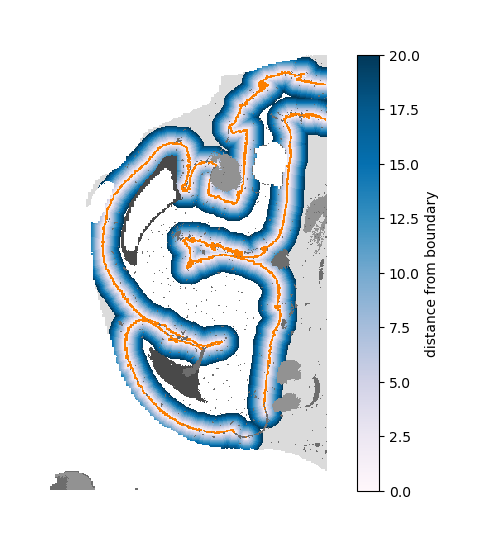

In [25]:
plt.close("all")
plot_boundary_distances(anndata, 
                    boundary_dist_key="boundary_dist_brain_meninges", 
                    verbose=True, 
                    manual_selection_key=None)

## manually select region

In [26]:
#anndata.obs=anndata.obs.drop(columns=["dorpal_meninges", "collsup_meninges", "dorpal_vent", "colsup_vent"], errors="raise")

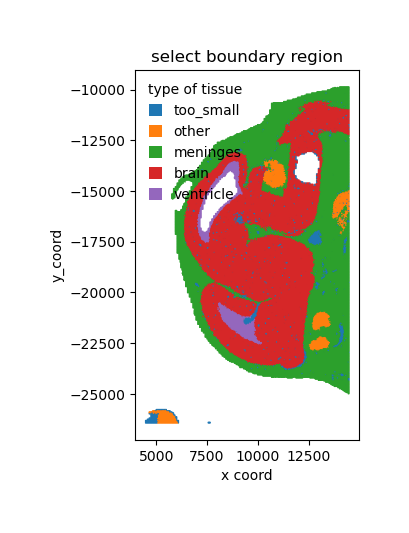

In [48]:
%matplotlib widget

selector = select_region_of_interest_categorical(anndata, set_nan_to_zero=False, s=1, col_name="filtered_annotated")

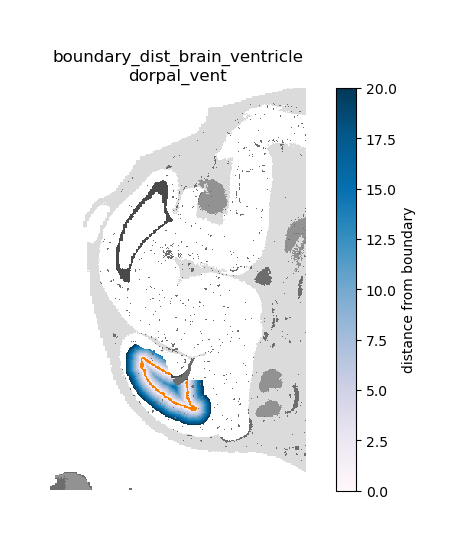

In [49]:
#rel_clusters = ["brain", "meninges"]
#boundary_dist_key = "boundary_dist_brain_meninges"
#selection_name = "colsup_men"
#selection_name = "dorpal_men"
#selection_name = "subpal_men"
#selection_name = "lowhind_men"
#selection_name = "highhind_men"

######
rel_clusters = ["brain", "ventricle"]
boundary_dist_key = "boundary_dist_brain_ventricle"
selection_name = "dorpal_vent"
#selection_name = "colsup_vent"


anndata = set_manually_selected_region(anndata, selector, col_name=selection_name)

plt.close("all")
plot_boundary_distances(anndata, 
                    boundary_dist_key=boundary_dist_key, 
                    verbose=True, 
                    manual_selection_key=selection_name,
                    highlight_boundary=True,
                    path=f"{out_dir}{sample_name}_{boundary_dist_key}_{selection_name}.png",
                    title=f"{boundary_dist_key}\n{selection_name}")


dist_gene_df = create_dist_gene_table(anndata,
                                      rel_clusters,
                                      raw_counts_layer="raw_counts", 
                                      boundary_dist_key=boundary_dist_key, 
                                      filepath=f"{out_dir}{sample_name}_{boundary_dist_key}_{selection_name}.tsv",
                                      filtered_clusters_key="filtered_annotated",
                                      masking_key=selection_name)

## CHANGE OUTPUT FILENAME

In [50]:
anndata.write(f"{out_dir}{sample_name}_processed_anndata.h5ad")

... storing 'leiden_annotated' as categorical
... storing 'filtered_annotated' as categorical


In [13]:
def find_boundary_distances(anndata, 
                              excluded_clusters=["too_small", "other"],
                              clusters_key="filtered_annotated",
                              is_boundary_key_prefix="is_boundary_",
                              min_boundary_length = 100,
                              boundary_dist_key_prefix="boundary_dist_",
                              boundary_range = 1,
                              max_dist=20,
                              print_modulo=1,
                              verbose=True):
    
    # 1. find spots that are boundary spots
        # have to be witin non masked area
        # boundary spot on both sides (in both tissues)
        # iterate over an arr of clusters
        #  only report actual boundary spots, in next separate step link boundaries
    region_arr = anndata.obs.pivot(columns="x", index="y", values=clusters_key).to_numpy() # x and y inverted so that matrix orientation fits image
    
    if verbose:
        print("marking boundary spots")
    
    relevant_clusters = np.unique(region_arr.astype("str"))
    relevant_clusters = [c for c in relevant_clusters if c not in excluded_clusters + ["nan"]]

    new_obs = copy.deepcopy(anndata.obs)
    
    for cluster_a, cluster_b in itertools.combinations(relevant_clusters, 2):
        if verbose:
            print(f"detecting boundaries between {cluster_a} and {cluster_b}")
        try:
            new_obs = new_obs.drop(columns=[is_boundary_key_prefix+cluster_a+"_"+cluster_b], errors="raise")
            if verbose: 
                print("deleted previous boundary result!")
        except KeyError:
            if verbose:
                print("no boundary column found. If first pass, all good")
        except Exception:
            raise ValueError('Removing of boundary failed. ERROR SOURCE UNKNOWN!')
        
        
        excluded_clusters_iteration = excluded_clusters + [c for c in relevant_clusters if c not in [cluster_a, cluster_b]]
        is_boundary_arr = np.full((len(region_arr), len(region_arr[0])), False)
        for i in range(len(region_arr)):
            for j in range(len(region_arr[0])):
                if is_boundary_spot(region_arr, i, j, excluded_clusters_iteration):
                    is_boundary_arr[i][j] = True
        
        if verbose:
            print("running boundary_recursion")
        
        checked = set()
        unique_boundaries = {}
        unique_boundary_id = 0
        for i in range(len(is_boundary_arr)):
            for j in range(len(is_boundary_arr[0])):
                if f"{i}_{j}" not in checked:
                    boundary_elements, checked = boundary_recursion(is_boundary_arr, [f"{i}_{j}"], checked, boundary_range)
                    if len(boundary_elements) > 0:
                        unique_boundaries[unique_boundary_id] = boundary_elements
                unique_boundary_id += 1
        
        max_length = 0
        for k in list(unique_boundaries.keys()):
            max_length = max(max_length, len(unique_boundaries[k]))
            if len(unique_boundaries[k]) < min_boundary_length:
                del unique_boundaries[k]
        
        
        if len(unique_boundaries) == 0:
            #raise ValueError(f"No boundaries long enough. Max length: {max_length}")
            print(f"No boundary long enough found between {cluster_a} and {cluster_b}. Max length found: {max_length}")
            continue
        
        boundaries_arr_bool = np.full((len(is_boundary_arr), len(is_boundary_arr[0])), False)

        new_obs = create_new_obs(is_boundary_arr,
                                 new_obs,
                                 is_boundary_key_prefix + cluster_a + "_"+cluster_b) # need to rename column for each cluster combination
        
        #4. pad up to max wanted dist
        boundary_distance_table = calculate_boundary_distance(new_obs,  
                                                              max_dist= max_dist,
                                                              testing_out_dir="", 
                                                              is_boundary_key=is_boundary_key_prefix +cluster_a + "_"+cluster_b, 
                                                              boundary_dist_key=boundary_dist_key_prefix + cluster_a + "_"+cluster_b, 
                                                              filtered_clusters_key=clusters_key, 
                                                              verbose=True,
                                                              print_modulo=print_modulo)
        
        ###
        try:
            new_obs = new_obs.drop(columns=[boundary_dist_key_prefix + cluster_a + "_"+cluster_b], errors="raise")
            if verbose: 
                print("deleted previous boundary dist result!")
        except KeyError:
            if verbose:
                print("no boundary dist column found. If first pass, all good")
        except Exception:
            raise ValueError('Removing of boundary failed. ERROR SOURCE UNKNOWN!')
        
        
        boundary_distance_column = pd.DataFrame(data=boundary_distance_table,    # values
                                                index=np.sort(new_obs["y"].unique()),    # 1st column as index
                                                columns=np.sort(new_obs["x"].unique()))  # 1st row as the column names
        boundary_distance_column = boundary_distance_column.stack().reset_index(name=boundary_dist_key_prefix+ cluster_a + "_"+cluster_b)
        boundary_distance_column = boundary_distance_column.rename(columns={"level_0": "y", "level_1": "x"})
        
        new_obs["_bin_names"] = new_obs.index
        new_new_obs = pd.merge(new_obs, boundary_distance_column,  how='left', left_on=['x','y'], right_on = ['x','y'])
        new_new_obs.index = new_new_obs["_bin_names"]
        new_new_obs = new_new_obs.drop('_bin_names', axis=1)
        
        new_new_obs.loc[new_new_obs[clusters_key].isin(excluded_clusters), boundary_dist_key_prefix+cluster_a+"_"+cluster_b] = np.nan
        new_new_obs=new_new_obs.drop(columns=[is_boundary_key_prefix +cluster_a + "_"+cluster_b], errors="raise")
        
        new_obs = copy.deepcopy(new_new_obs)
    
    return new_obs


def set_annotation_by_region(df, 
                             region=None, 
                             annotation=None,
                             annotation_key="filtered_annotated",
                             region_num_key="region_num_key"):
    
    if region == None or annotation == None:
        raise ValueError('ERROR: Region or annotation not set')

    df[annotation_key] = np.where(df[region_num_key] == region,
                                  annotation,
                                  df[annotation_key])
    
    return df

def select_region_of_interest_categorical(anndata, set_nan_to_zero=False, col_name="filtered_annotated", s=0.5):
    temp = anndata.raw.to_adata()
    set_nan_to_zero = False
    test_red = temp.obs[["x", "y", col_name]]
    if set_nan_to_zero:
        print("adding missing fields")
        
        for x in test_red["x"].unique():
            for y in test_red["y"].unique():
                if test_red.loc[(test_red["x"] == x) & (test_red["y"] == y)].shape[0] == 0:
                    new_bin = pd.DataFrame([{'x':x, 'y':y, col_name:0}])
                    test_red = pd.concat([test_red, new_bin], ignore_index=True)
    plt.close("all")
    
    
    fig, ax = plt.subplots()
    
    levels, categories = pd.factorize(test_red[col_name])
    colors = [plt.cm.tab10(i) for i in levels] # using the "tab10" colormap
    handles = [mpatches.Patch(color=plt.cm.tab10(i), label=c) for i, c in enumerate(categories)]
    
    im = ax.scatter(test_red['x'], test_red['y']*-1, c=colors, s=s)
    plt.gca().set(xlabel='x coord', ylabel='y_coord', title='select boundary region')
    plt.gca().set_aspect("equal")
    plt.legend(handles=handles, title='type of tissue')

    selector = SelectFromCollection(ax, im)
    
    # https://matplotlib.org/stable/gallery/widgets/lasso_selector_demo_sgskip.html
    def accept(event):
        if event.key == "enter":
            print("Selected points:")
            print(selector.xys[selector.ind])
            selector.disconnect()
            ax.set_title("")
            fig.canvas.draw()

    fig.canvas.mpl_connect("key_press_event", accept)
    plt.show()
    
    return selector


def plot_boundary_distances(data, 
                        boundary_dist_key="boundary_dist", 
                        annotation_key="filtered_annotated", 
                        manual_selection_key=None,
                        verbose=True, 
                        dist_val=None,
                        highlight_boundary=True,
                        path=None,
                        title=None):

    if boundary_dist_key not in data.obs.columns:
        raise ValueError(f"{boundary_dist_key} not in object")
        
    df_tmp = copy.deepcopy(data.obs)
    table_regions = df_tmp.pivot("y", "x", annotation_key).values # x and y inverted so that matrix orientation fits image
    region_arr_plotting = np.full((len(table_regions), len(table_regions[0])), np.nan)
    table_regions = table_regions.astype("str")
    unique_annotations = np.unique(table_regions)
    for i in range(len(table_regions)):
        for j in range(len(table_regions[i])):
            plot_val = table_regions[i][j]
            if plot_val == "nan":
                continue
            region_arr_plotting[i][j] = np.where(unique_annotations==plot_val)[0][0]
    
    table_dist = df_tmp.pivot("y", "x", boundary_dist_key).values # x and y inverted so that matrix orientation fits image
    if manual_selection_key != None:
        table_mask = df_tmp.pivot("y", "x", manual_selection_key).values # x and y inverted so that matrix orientation fits image
    
    distance_arr_plotting = np.full((len(table_dist), len(table_dist[0])), np.nan)

    
    for i in range(len(table_dist)):
        for j in range(len(table_dist[i])):
            if manual_selection_key != None:
                if table_mask[i][j]:
                    distance_arr_plotting[i][j] = table_dist[i][j]
            else:
                distance_arr_plotting[i][j] = table_dist[i][j]
    
    
    #plt.close("all")
    plt.imshow(region_arr_plotting, interpolation="none", cmap="binary", vmin=0, vmax=7)
    plt.axis("off")
    plt.tight_layout()
    
    plt.imshow(distance_arr_plotting, interpolation="none", cmap="PuBu", vmin=0, vmax=np.nanmax(distance_arr_plotting)) # vmin usefull to set middle of color map to 0
    plt.colorbar(label="distance from boundary")
    plt.axis('off')
    plt.tight_layout()

    if highlight_boundary:
        distance_arr_plotting[distance_arr_plotting!=1] = np.nan
        plt.imshow(distance_arr_plotting, interpolation="none", cmap="Wistia_r") # vmin usefull to set middle of color map to 0
        plt.tight_layout()
        plt.axis('off')

    if title != None:
        plt.title(title)
    
    plt.tight_layout()
    
    if path != None:
        plt.savefig(path, dpi=600)
    
    plt.show()


def vars(a, axis=None):
    """ Variance of sparse matrix a
    var = mean(a**2) - mean(a)**2
    source: https://gist.github.com/sumartoyo/edba2eee645457a98fdf046e1b4297e4
    """
    a_squared = a.copy()
    a_squared.data **= 2
    return a_squared.mean(axis) - np.square(a.mean(axis))

def stds(a, axis=None):
    """ Standard deviation of sparse matrix a
    std = sqrt(var(a))
    source: https://gist.github.com/sumartoyo/edba2eee645457a98fdf046e1b4297e4
    """
    return np.sqrt(vars(a, axis))


def calculate_boundary_distance(obs,
                            max_dist = 20,
                            testing_out_dir="", 
                            is_boundary_key="is_boundary", 
                            boundary_dist_key="boundary_dist", 
                            filtered_clusters_key="filtered_annotated", 
                            boolean_masking_col=None,
                            verbose=True,
                            print_modulo=1):
    
    is_boundary_table = obs.pivot(index="y", columns="x", values=is_boundary_key).values
    annotation_table = obs.pivot(index="y", columns="x", values=filtered_clusters_key).values
    boolean_masking_arr = obs.pivot(index="y", columns="x", values=boolean_masking_col).values
    boundary_distance_table = np.full((len(is_boundary_table), len(is_boundary_table[0])), np.nan)
    
    for n in range(max_dist, 0, -1):
        if verbose and n%print_modulo == 0:
            print(f"calculating spots with boundary distance: {n}")
        for i in range(0, len(is_boundary_table)-1):
            for j in range(len(is_boundary_table[i])-1):
                if is_boundary_table[i][j] and not np.isnan(is_boundary_table[i][j]):
                    rr, cc = disk((i, j), n)
                    for k in range(len(rr)):
                        if rr[k] < len(is_boundary_table) and cc[k] < len(is_boundary_table[0]) and rr[k] >= 0 and cc[k] >= 0:  # negative integers makes it wrap around
                            if annotation_table[rr[k]][cc[k]] == annotation_table[i][j]:# make sure that only boundariespot of same celltype is used to calculate distances in a tissue, otherwise one side of the dge will get completely overwritten
                                if boolean_masking_col == None:
                                    boundary_distance_table[rr[k]][cc[k]] = n
                                elif boolean_masking_col != None and boolean_masking_arr[rr[k]][cc[k]]:
                                    boundary_distance_table[rr[k]][cc[k]] = n
                                    
    return boundary_distance_table


def is_boundary_spot(arr, 
                 i, 
                 j, 
                 excluded_clusters=["too_small", "other"]):
    
    if arr[i][j] not in excluded_clusters:
        for ii in range(max(0, i-1), min(i+2, len(arr))):
            for jj in range(max(0, j-1), min(j+2, len(arr[0]))):
                if arr[i][j] != arr[ii][jj] and arr[ii][jj] not in excluded_clusters and not pd.isna(arr[ii][jj]):
                    return True
    
    return False

def boundary_recursion(is_boundary_arr, to_check, checked, boundary_range):
    boundary_elements = []
    while len(to_check) != 0:
        checked.add(to_check[0])
        i = int(to_check[0].split("_")[0])
        j = int(to_check[0].split("_")[1])
        
        if is_boundary_arr[i][j]:
            boundary_elements.append(to_check[0])
            ############# circular check for nearest other boundary spot
            
            rr, cc = disk((i, j), boundary_range+2) # boundary_range=1 means it can skip empty field. skipping none: boundary_range=0. if disk((x,y)n) n=1: will only return the coordinates [x,y                for k in range(len(rr)):
            for k in range(len(rr)):
                if rr[k] < len(is_boundary_arr) and cc[k] < len(is_boundary_arr[0]) and rr[k] >= 0 and cc[k] >= 0:  # negative integers makes it wrap around
                    if f"{rr[k]}_{cc[k]}" not in checked and f"{rr[k]}_{cc[k]}" not in to_check:
                        to_check.append(f"{rr[k]}_{cc[k]}")

        del to_check[0]
    
    return boundary_elements, checked


def create_new_obs(boundaries_arr_bool,
                   df,
                   is_boundary_key):
    
    boundaries_arr_bool = pd.DataFrame(data=boundaries_arr_bool,    # values
                        index=np.sort(df["y"].unique()),    # 1st column as index
                        columns=np.sort(df["x"].unique()))  # 1st row as the column names
    boundaries_arr_bool = boundaries_arr_bool.stack().reset_index(name=is_boundary_key)
    boundaries_arr_bool = boundaries_arr_bool.rename(columns={"level_0": "y", "level_1": "x"})
    
    df["_bin_names"] = df.index
    new_obs = pd.merge(df, boundaries_arr_bool,  how='left', left_on=['x','y'], right_on = ['x','y'])
    new_obs.index = new_obs["_bin_names"]
    new_obs = new_obs.drop('_bin_names', axis=1)

    return new_obs


def calculate_dist_gene_df(anndata_raw, 
                           relevant_clusters, 
                           boundary_dist_key="boundary_dist", 
                           filtered_clusters_key="filtered_annotated", 
                           bin_count_key = "bin_count",
                           masking_key=None):
    
    if len(relevant_clusters) == 1:
        relevant_clusters.append("background")
    temp = copy.deepcopy(anndata_raw.obs)
    if masking_key != None:
        temp[boundary_dist_key] = np.where(temp[masking_key] == True,
                                       temp[boundary_dist_key],
                                       np.nan)
        
    temp[boundary_dist_key] = temp[boundary_dist_key].astype("category")
    dist_gene_df = pd.DataFrame(columns=anndata_raw.var_names, index=temp[boundary_dist_key].cat.categories)
    stdev_gene_df = pd.DataFrame(columns=anndata_raw.var_names, index=temp[boundary_dist_key].cat.categories)
    
    temp[boundary_dist_key] = temp[boundary_dist_key].astype("category")
    anndata_raw.obs = temp
    
    for distance in anndata_raw.obs[boundary_dist_key].astype("category").cat.categories:
        dist_gene_df.loc[distance] = anndata_raw[anndata_raw.obs[boundary_dist_key].isin([distance]),:].layers["normalized"].mean(axis=0)
        #stdev_gene_df.loc[distance] = stds(anndata_raw[anndata_raw.obs[boundary_dist_key].isin([distance]),:].layers["normalized"], axis=0) # population standard deviation, lots of outliers in data (sparse data) make it unsuited
        x = anndata_raw[anndata_raw.obs[boundary_dist_key].isin([distance]),:].layers["normalized"].todense()
        stdev_gene_df.loc[distance] = np.median(np.absolute(x - np.median(x, axis=0)),axis=0)
    dist_gene_df.index = dist_gene_df.index.astype("int")
    stdev_gene_df.index = stdev_gene_df.index.astype("int")
    
    dist_gene_df[bin_count_key] = anndata_raw.obs[boundary_dist_key].value_counts()
    
    column_to_move = dist_gene_df.pop(bin_count_key)
    dist_gene_df.insert(0, bin_count_key, column_to_move)
    
    return dist_gene_df, stdev_gene_df


def plot_two_obs_column(anndata, colouring_column, boolean_column): # one has to be boolean
    import matplotlib.patches as mpatches
    temp = copy.deepcopy(anndata.obs)  
    temp[colouring_column].unique()
    
    temp["_temp_col"] = temp[colouring_column]
    temp['_temp_col'] = temp['_temp_col'].astype("str") 
    temp.loc[temp[boolean_column] != True, '_temp_col'] = "masked"
    
    translation = dict()
    rev_translation = dict()
    
    i = 1
    values = temp["_temp_col"].unique()
    for val in values:
        translation[val] = i
        rev_translation[i] = val
        i += 1
    
    temp = temp.replace({"_temp_col" : translation})
    #print(translation)
    
    table = temp.pivot("y", "x", "_temp_col") # x and y inverted so that matrix orientation fits image
    
    #values = np.unique(table.values.ravel())
    im = plt.imshow(table, cmap="Set1", interpolation="none")
    plt.axis('off')
    #https://stackoverflow.com/questions/25482876/how-to-add-legend-to-imshow-in-matplotlib
    colors = [ im.cmap(im.norm(value+1)) for value in range(len(values))]
    patches = [ Patch(color=colors[i], label="{l}".format(l=rev_translation[i+1]) ) for i in range(len(values)) ] # i+1 because translation dic starts at 1 
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
    plt.show()
    #plt.savefig(path)
    #plt.close()


def plot_heatmap_stereo(data, 
                        genes=None, 
                        region=None, 
                        num_x_ticks=10, 
                        num_y_ticks=10, 
                        title="",
                        out_path="",
                        out_dpi=300): # genes either ["all"] or list of genes
    if isinstance(data, st.core.stereo_exp_data.StereoExpData):
        df_tmp = data.tl.raw.to_df()
        df_tmp["x"] = pd.DataFrame(data.position[:,0], index = data.cell_names)
        df_tmp["y"] = pd.DataFrame(data.position[:,1], index = data.cell_names)  
    if genes is None:
        df_tmp["total"] = df_tmp.sum(axis=1)
    else:
        genes = [gene for gene in genes if gene in df_tmp.columns]
        if len(genes) == 0:
            raise Warning('none of the genes found')
            return
        df_tmp['total'] = df_tmp.loc[:,genes].sum(axis=1)
    
    
    table = df_tmp.pivot("y", "x", "total") # x and y inverted so that matrix orientation fits image
    if region is not None:
        table = table.loc[region[2]:region[3], region[0]:region[1]]
    
    plt.imshow(table)
    plt.axis('off')
    cbar = plt.colorbar(label=f'exp. {" + ".join(str(i) for i in genes)}', ticks=None)
    cbar.set_ticks([0,np.nanmax(table.values)])
    cbar.set_ticklabels(["min","max"])
    
    if title != "":
        plt.title(title)
    
    if out_path == "":
        plt.show()
    else:
        plt.savefig(out_path, dpi=out_dpi)
        plt.close()


def plot_clustering_ranges(data, 
                           sample_name, 
                           path, 
                           leiden_range=[0.05, 0.075, 0.1, 0.15, 0.2], 
                           verbose=True, 
                           seed=1, 
                           plot_umap=False):
    if verbose:
        print(f"Plotting ranges of clustering resolutions")
    
    for res in leiden_range:
        if verbose:
            print(f"Working on resolution: {res}")
        data.tl.leiden(neighbors_res_key="neighbors", res_key="leiden", resolution=res, random_state=seed) # random_state=0 is default
        
        data.plt.cluster_scatter(res_key="leiden")
        plt.tight_layout()
        plt.savefig(f"{path}{sample_name}_leiden_{res}.png")
        plt.close()
        
        if plot_umap:
            data.plt.umap(res_key='umap', cluster_key='leiden')
            plt.tight_layout()
            plt.savefig(f"{path}{sample_name}_leiden_{res}_umap.png")
            plt.close()

def visually_control_selector(anndata, selector, cluster_key = "filtered_annotated"):
    #anndata.obs["filtered_annotated"] = anndata.obs["leiden_annotated"]
    test_masking = copy.deepcopy(anndata)
    test_masking.obs["_temp"] = "not_of_interest"
    #test_masking = test_masking.astype({"filtered_annotated": str})
    for elem in selector.xys[selector.ind]:
        test_masking.obs.loc[(test_masking.obs['x'] == elem[0]) & (test_masking.obs['y'] == elem[1]*-1),'_temp'] = 'region_of_interest'

    test_masking.obs[cluster_key] = test_masking.obs[cluster_key].astype("str") # forces correct type, in case column was converted to categoricl (f.ex. while saving object)
    test_masking.obs.loc[(test_masking.obs['_temp'] == "not_of_interest"), cluster_key] = 'masked'
    
    plt.close("all")
    plot_obs_column(test_masking, cluster_key)
    #plt.close("all")

def set_manually_selected_region(anndata, selector, col_name="manually_selected"):
    anndata.obs[col_name] = False
    #test_masking = test_masking.astype({"filtered_annotated": str})
    for elem in selector.xys[selector.ind]:
        anndata.obs.loc[(anndata.obs['x'] == elem[0]) & (anndata.obs['y'] == elem[1]*-1),col_name] = True
    
    return anndata



def set_cluster_names(data,
                      resolution,
                      cluster_dic,
                      verbose = True, 
                      path=None,
                      annotation_key="leiden_annotated",
                      algorithm="leiden"):
    if verbose:
        print("Setting cluster names.")
    
    temp_data = copy.deepcopy(data.tl.result[algorithm])
    temp_data["group"] = temp_data["group"].astype("str")
    temp_data["annotation"] = "other"
    
    for leiden_cluster in cluster_dic:
        temp_data.loc[(temp_data['group'] == str(leiden_cluster)), 'annotation'] = cluster_dic[leiden_cluster]
    
    temp_data["group"] = temp_data["annotation"]
    data.tl.result._set_cluster_res(annotation_key, temp_data) # stereopy has different types of result. "cluster_res" can only save one column called "group". https://github.com/STOmics/Stereopy/blob/main/stereo/core/result.py
    del temp_data
    
    data.plt.cluster_scatter(res_key=annotation_key)
    plt.tight_layout()
    plt.show()


def spot_recursion(to_check, 
                   checked, 
                   unique_regions, 
                   region_num, 
                   current_tissue, 
                   table_np):#table, i ,j, width, min_size, checked_pos):
    
        for position in to_check:
            k = position[0]
            l = position[1]
            
            
            try:
                if (current_tissue == table_np[k][l]) and (k >= 0 and l >= 0) and not (f"{k}_{l}" in checked):
                    checked.add(f"{k}_{l}")
                    #print("adding")
                    unique_regions[region_num].add(f"{k}_{l}")
                    to_check.extend([[k+0, l+1], 
                                 [k+0, l-1],
                                 [k+1, l], 
                                 [k+1, l+1], 
                                 [k+1, l-1],
                                 [k-1, l], 
                                 [k-1, l+1], 
                                 [k-1, l-1]])
            except Exception:
                continue
        # if the list is empty, return
        return checked, unique_regions
        

def filter_regions(data, 
                   column_to_filter_key="leiden_annotated", 
                   filtered_column_key ="filtered_annotated", 
                   verbose=True, 
                   region_num_key="region_num_key",
                   clustering_algo = "leiden",
                   min_region_size=500
                   ):
    
    print("Have to check if x and y coordinates are actually integers, can cause awful issues if they arent (floating point inaccuracy, casting int(0.99999) = 0, etc)")
    if verbose:
        print("filtering regions by size")
    
    #try:
    #    data.obs = data.obs.drop(columns=[filtered_column_key], errors="raise")
    #    if verbose: 
    #        print("deleted previews region filtering result!")
    #except KeyError:
    #    print("no filtered clusters column found. If first pass, all good")
    #except Exception:
    #    raise ValueError('Removing of filtered regions failed. ERROR SOURCE UNKNOWN!')
        
    try:
        data.obs = data.obs.drop(columns=[region_num_key], errors="raise")
        if verbose: 
            print("deleted previews region num key result!")
    except KeyError:
        print("no region num key column found. If first pass, all good")
    except Exception:
        raise ValueError('Removing of region num key failed. ERROR SOURCE UNKNOWN!')
    
    
    small_df = data.obs[["y", "x", column_to_filter_key]]
    small_df[["y", "x"]] = small_df[["y", "x"]].astype("int")
    #small_df[f"{column_to_filter_key}_translated"] = pd.factorize(small_df[column_to_filter_key])[0]
    table_np = small_df.pivot("y", "x", column_to_filter_key).to_numpy()
    
    
    checked = set()
    to_check = []
    unique_regions = dict()
    too_small_regions = []
    region_num = 0
    
    # detecting all regions, regardless of size
    for i in range(0, len(table_np)-1):
        for j in range(len(table_np[i])-1):
            if f"{i}_{j}" not in checked:
                to_check = [[i, j]]
                unique_regions[region_num] = set()
                
                checked, unique_regions = spot_recursion(to_check, checked, unique_regions, region_num, table_np[i][j], table_np)
                if len(unique_regions[region_num]) < min_region_size:
                    too_small_regions += unique_regions[region_num]
                    del unique_regions[region_num]
                else:
                    region_num = region_num+1
    
    if region_num == 1:
        raise ValueError(f"No region big enough.")
    #return arr_all
    
    arr_all = np.full((len(table_np), len(table_np[0])), np.nan)
    arr_all_toosmall = np.full((len(table_np), len(table_np[0])), np.nan)
    cluster_count = 1
    max_region_size = 0
    for key in unique_regions:
        for elem in unique_regions[key]:
            i = int(elem.split("_")[0])
            j = int(elem.split("_")[1])
            arr_all[i][j] = key

    for pos in too_small_regions:
        i = int(pos.split("_")[0])
        j = int(pos.split("_")[1])
        arr_all_toosmall[i][j] = 1
    
    
    im = plt.imshow(arr_all, cmap="tab20", interpolation='none')
    plt.tight_layout()
    plt.axis('off')
    
    # source: https://stackoverflow.com/questions/25482876/how-to-add-legend-to-imshow-in-matplotlib
    values = np.unique(arr_all.ravel())
    colors = [ im.cmap(im.norm(value)) for value in values[:-1]]
    patches = [ mpatches.Patch(color=colors[i], label=f"region {str(values[i]).split('.')[0]}: {len(unique_regions[i])}") for i in range(len(values[:-1]))]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
    
    plt.show()


    im2 = plt.imshow(arr_all_toosmall, interpolation='none')
    plt.tight_layout()
    plt.axis('off')
    plt.show()
    
    # create column in .obs this region number of each bin
    arr_all = pd.DataFrame(data=arr_all,    # values
                           index=np.sort(anndata.obs["y"].unique()),    # 1st column as index
                           columns=np.sort(anndata.obs["x"].unique()))  # 1st row as the column names
    
    arr_all = arr_all.stack().reset_index(name=region_num_key)
    arr_all = arr_all.rename(columns={"level_0": "y", "level_1": "x"})
    #arr_all[region_num_key] = pd.Categorical(arr_all[region_num_key]) # breaks plotting
    
    data.obs["_bin_names"] = data.obs.index
    new_obs = pd.merge(data.obs, arr_all,  how='left', left_on=['x','y'], right_on = ['x','y'])
    new_obs.index = new_obs["_bin_names"]
    #new_obs = new_obs.drop('_bin_names', axis=1)
    
    
    
    big_enough = dict()
    for key in unique_regions:
        if len(unique_regions[key]) > min_region_size:
            big_enough[key] = unique_regions[key]
            
    
    big_enough = list(big_enough.values())
    big_enough_elements = [item for sublist in big_enough for item in sublist]
    
    # set all spots that do not belong to large regions to -1
    # -1 used for spots that should be ignored, NOT treated like nan (masking region)
    big_enough_elements = set(big_enough_elements)
    for i in range(0, len(table_np)):
        for j in range(len(table_np[i])):
            try:
                if f"{i}_{j}" not in big_enough_elements and not pd.isnull(table_np[i][j]):
                    table_np[i][j] = "too_small"
            except Exception:
                return table_np[i][j]
    
    table_np = pd.DataFrame(data=table_np,    # values
                        index=np.sort(anndata.obs["y"].unique()),    # 1st column as index
                        columns=np.sort(anndata.obs["x"].unique()))  # 1st row as the column names
    table_np = table_np.stack().reset_index(name=filtered_column_key)
    table_np = table_np.rename(columns={"level_0": "y", "level_1": "x"})
    
    #data.obs["_bin_names"] = data.obs.index
    if filtered_column_key in new_obs.columns:
        new_obs = new_obs.drop(filtered_column_key, axis=1)
    new_obs = pd.merge(new_obs, table_np,  how='left', left_on=['x','y'], right_on = ['x','y'])
    
    new_obs.index = new_obs["_bin_names"]
    
    new_obs = new_obs.drop('_bin_names', axis=1)
    
    return new_obs


def create_dist_gene_table(anndata, 
                           relevant_clusters, 
                           raw_counts_layer="raw_counts", 
                           boundary_dist_key="boundary_dist", 
                           normalization_target_sum=1e6, 
                           filepath=None, 
                           masking_key=None,
                           filtered_clusters_key="filtered_annotated"):
    
    anndata_raw = anndata.raw.to_adata()
    anndata_raw.layers[raw_counts_layer] = copy.deepcopy(anndata_raw.X)

    ###
    anndata_raw.obs[boundary_dist_key] = np.where(anndata_raw.obs[filtered_clusters_key] == relevant_clusters[0],
                                              anndata_raw.obs[boundary_dist_key],
                                              anndata_raw.obs[boundary_dist_key]*-1)
    ###
    
    sc.pp.normalize_total(anndata_raw, target_sum=normalization_target_sum)
    anndata_raw.layers["normalized"] = copy.deepcopy(anndata_raw.X)
    dist_gene_df, stdev_gene_df = calculate_dist_gene_df(anndata_raw, 
                                                         relevant_clusters, 
                                                         boundary_dist_key=boundary_dist_key,
                                                         masking_key=masking_key)
    
    stdev_gene_df = stdev_gene_df.add_suffix("__stdev") # make columns distinguishable by adding __stdev suffic
    conc = pd.concat([dist_gene_df, stdev_gene_df], axis=1)
    
    # https://stackoverflow.com/questions/3678869/pythonic-way-to-combine-interleave-interlace-intertwine-two-lists-in-an-alte
    new_col_order = [x for x in itertools.chain.from_iterable(itertools.zip_longest(dist_gene_df.columns, stdev_gene_df.columns)) if x]
    conc = conc[new_col_order] # sort columns, so that expression values and stdev values are always neighboring columns
    
    if filepath is not None:
        with open(filepath, 'w') as f:
            f.write(f'# {relevant_clusters[1]}: negative distances, {relevant_clusters[0]}: positive distances\n')
            conc.to_csv(f, 
                                sep="\t",
                                header=True,
                                decimal=".")
        f.close()
    
    return conc

    
def plot_obs_column(anndata, column_key): # would be nice to have option to select region to plot based on column, and colour by other column. f.ex. select by wht was manually selected, colour by annotation
    import matplotlib.patches as mpatches
    temp = copy.deepcopy(anndata.obs)  
    temp[column_key].unique()
    
    translation = dict()
    rev_translation = dict()
    
    i = 1
    values = temp[column_key].unique()
    for val in values:
        translation[val] = i
        rev_translation[i] = val
        i += 1
    
    temp["_translated"] = temp.replace({column_key: translation})[column_key]
    
    table = temp.pivot("y", "x", "_translated") # x and y inverted so that matrix orientation fits image
    
    #values = np.unique(table.values.ravel())
    im = plt.imshow(table, cmap="Set1", interpolation="none")
    plt.axis('off')
    #https://stackoverflow.com/questions/25482876/how-to-add-legend-to-imshow-in-matplotlib
    colors = [ im.cmap(im.norm(value+1)) for value in range(len(values))]
    patches = [ mpatches.Patch(color=colors[i], label="{l}".format(l=rev_translation[i+1]) ) for i in range(len(values)) ] # i+1 because translation dic starts at 1 
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
    plt.show()
    #plt.savefig(path)
    #plt.close()

class SelectFromCollection:
    """
    Select indices from a matplotlib collection using `LassoSelector`.
    
    Selected indices are saved in the `ind` attribute. This tool fades out the
    points that are not part of the selection (i.e., reduces their alpha
    values). If your collection has alpha < 1, this tool will permanently
    alter the alpha values.
    
    Note that this tool selects collection objects based on their *origins*
    (i.e., `offsets`).
    
    Parameters
    ----------
    ax : `~matplotlib.axes.Axes`
        Axes to interact with.
    collection : `matplotlib.collections.Collection` subclass
        Collection you want to select from.
    alpha_other : 0 <= float <= 1
        To highlight a selection, this tool sets all selected points to an
        alpha value of 1 and non-selected points to *alpha_other*.
    """
    
    def __init__(self, ax, collection, alpha_other=0.3):
        self.canvas = ax.figure.canvas
        self.collection = collection
        self.alpha_other = alpha_other
        
        self.xys = collection.get_offsets()
        self.Npts = len(self.xys)
        
        # Ensure that we have separate colors for each object
        self.fc = collection.get_facecolors()
        if len(self.fc) == 0:
            raise ValueError('Collection must have a facecolor')
        elif len(self.fc) == 1:
            self.fc = np.tile(self.fc, (self.Npts, 1))
        
        self.lasso = LassoSelector(ax, onselect=self.onselect)
        self.ind = []
    
    def onselect(self, verts):
        path = Path(verts)
        self.ind = np.nonzero(path.contains_points(self.xys))[0]
        self.fc[:, -1] = self.alpha_other
        self.fc[self.ind, -1] = 1
        self.collection.set_facecolors(self.fc)
        self.canvas.draw_idle()
    
    def disconnect(self):
        self.lasso.disconnect_events()
        self.fc[:, -1] = 1
        self.collection.set_facecolors(self.fc)
        self.canvas.draw_idle()
